# Assignment 4: Anomaly Detection with VAEs
<b>Group 58</b>
* <b> Student 1 </b> : Luc Reinink, 1068948
* <b> Student 2 </b> : Gerrit Merz, 1553410

As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density approximation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

In this task, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

In this assignment, we will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.

**NOTE:**
* **Only fill in the cells marked with `#### INSERT CODE HERE ####` or `<-- WRITE TEXT HERE -->`**
* **Do not add or delete any cells**
* **Make sure to run all cells before handing in.**
* **Re-running all cells in your notebook in order should produce similar output (it may vary slightly due to stochasticity in the training).**
* **You don't need to extensively comment your code, but briefly mention any assumptions you make, or any design choices.**
* **Make sure that the cell output (where needed) is clear and easy to interpret (i.e. print what it is you are outputting, captions/titles for plots).**

## Imports
These should be all the imports you'll need, please don't use any other libraries as this will make it harder to assess your work.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, precision_recall_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1: Obtain anomaly detection dataset
**(a)** We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.
* Load the FashionMNIST dataset.
* Remove all instances from the anomaly class from the training set.
* Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels).

*Implementation hint: `np.argwhere` may be helpful for splitting the data based on its labels.*

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

# rescale data
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

train_images = np.pad(train_images, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), 
                      mode="constant", constant_values=0)
test_images = np.pad(test_images, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), 
                     mode="constant", constant_values=0)

anomaly_digit = 1

print("Train images:", train_images.shape)
print("Test images:", test_images.shape)
print("Train trouser images:", train_images[train_labels == anomaly_digit].shape)
#each class has 6000 data points

#remove instances from the anomaly class from the training set
train_anomalies = train_images[train_labels == anomaly_digit]
train_images = train_images[train_labels != anomaly_digit]
print("Train images without trousers:", train_images.shape)

# get number of training samples, height, width, and depth values
n_train, height, width, depth = train_images.shape

#split test set in two parts (each class has 1000 data points)
print("Test images:", test_images.shape)
test_anomalies = test_images[test_labels == anomaly_digit]
test_images = test_images[test_labels != anomaly_digit]
print("Test images without trousers:", test_images.shape)
print("Test images, trousers only:", test_anomalies.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train images: (60000, 32, 32, 1)
Test images: (10000, 32, 32, 1)
Train trouser images: (6000, 32, 32, 1)
Train images without trousers: (54000, 32, 32, 1)
Test images: (10000, 32, 32, 1)
Test images without trousers: (9000, 32, 32, 1)
Test images, trousers only: (1000, 32, 32, 1)


**(b)** To check if the split was done correctly, plot some random examples (at least 10 each) of:
* The new training set (without the anomaly class)
* The normal test set
* The anomaly test set

New training set 



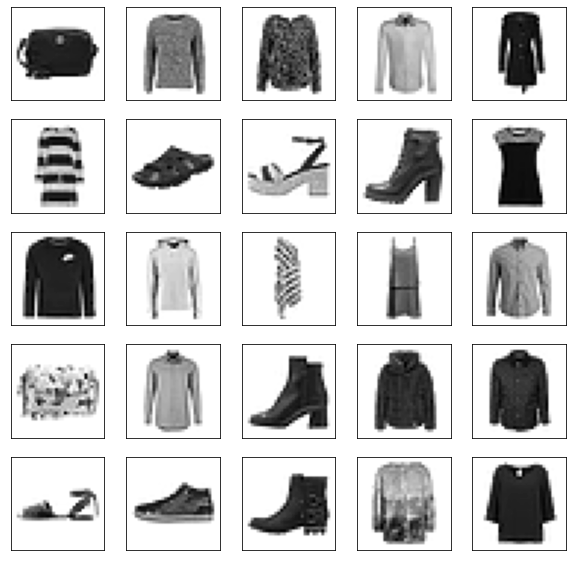

Normal test set 



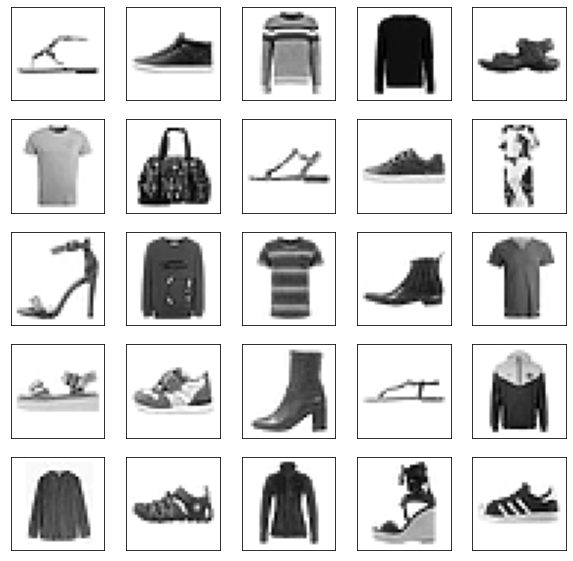

Anomaly test set 



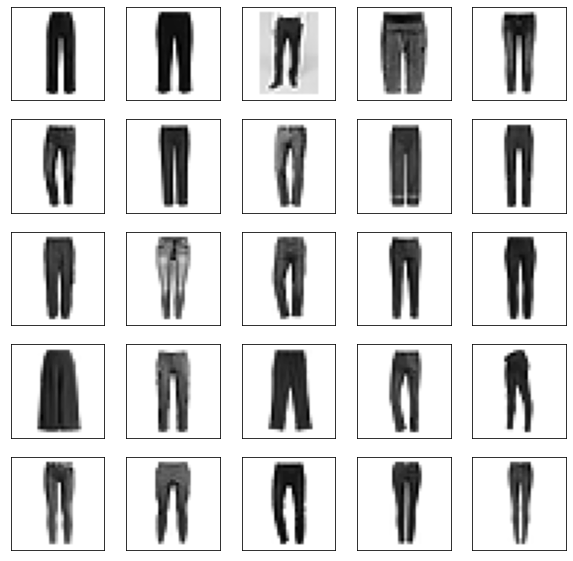

In [3]:
import random

def plot_random_images(arr, title, img_count=25):
    print(title, '\n')
    plt.figure(figsize=(10,10))
    for i in range(img_count):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = arr[random.randint(0, len(arr) - 1)].reshape(height, width)
        plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

plot_random_images(train_images, "New training set")
plot_random_images(test_images, "Normal test set")
plot_random_images(test_anomalies, "Anomaly test set")

## Task 2: Design, implement, and train a VAE
**(a)** Design a VAE for the FashionMNIST dataset with a suitable architecture, that should perform well on this dataset.
* Implement the VAE (with corresponding loss functions) and compile it.
* Print a summary (with `.summary()`) of the encoder and decoder.

*Hint: in Practical 6.1 we used a latent dimension of 2 because it allows for nice latent space plots. This limits the capacity of the VAE however, so here you will want to choose a higher number.*

In [4]:
latent_dim = 5

# input
x_in = layers.Input(shape=(height, width, depth), name="encoder_input")

# conv block 1
h = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                  activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)

# conv block 2
h = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                  activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)

# dense layers
h = layers.Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = layers.Dense(256, activation="relu")(h)                   # (8*8*128,)  -> (256,)
h = layers.Dense(128, activation="relu")(h)                   # (256,) -> (128,)
z_mu = layers.Dense(latent_dim, name='z_mu')(h)               # mu parameter of q(z|x)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h) # log of sigma parameter of q(z|x)

# create the encoder model
encoder = Model(x_in, [z_mu, z_log_sigma], name='encoder')
encoder.summary()

class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mu)), mean=0, stddev=1)
        return z_mu + K.exp(z_log_sigma) * epsilon

# use reparametrisation trick to sample from q(z|x)
z_sample = GaussianSampling(name="z_sample")([z_mu, z_log_sigma])

# build decoder model
dec_in = layers.Input(shape=(latent_dim, ), name='dec_in')

# reverse dense layers
h = layers.Dense(128, activation="relu")(dec_in)   # (32,) -> (128,) (encoding dimension)
h = layers.Dense(256, activation="relu")(h)        # (128, -> (256,)
h = layers.Dense(8*8*128, activation="relu")(h)    # (256,)     -> (8*8*128,)
h = layers.Reshape((8, 8, 128))(h)                 # (8*8*128,) -> (8, 8, 128)

# reverse conv block 2
h = layers.UpSampling2D(size=(2, 2))(h)            # (8, 8, 128  ) -> (16, 16, 128)
h = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                  activation='relu')(h)            # (16, 16, 128) -> (16, 16, 64)

# reverse conv block 1
h = layers.UpSampling2D(size=(2, 2))(h)            # (16, 16, 64) -> (32, 32, 64)
x_out = layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same",
                      activation='sigmoid')(h)     # (32, 32, 64) -> (32, 32, 1)

# instantiate decoder model
decoder = Model(dec_in, x_out, name='decoder')
decoder.summary()

x_mean = decoder(z_sample)
vae = Model(x_in, x_mean)

# flatten x_in and x_mean to shape (batch_size, n_pixels)
x_in_flat = K.batch_flatten(x_in)
x_mean_flat = K.batch_flatten(x_mean)

# fixed value for the standard deviation of p(x|z):
x_std = (1 / np.sqrt(2)).astype(np.float32)  # float32 to match Keras Tensors

reconstruction_loss = K.sum(K.square(x_in_flat - x_mean_flat) / (2 * x_std**2) +
                            K.log(x_std) + 0.5 * K.log(2 * np.pi), axis=-1)
kl_loss = 0.5 * K.sum(K.square(z_mu) + K.exp(2 * z_log_sigma) - 2 * z_log_sigma - 1, axis=-1)

# combine both losses
vae_loss = reconstruction_loss + kl_loss

# we use .add_loss instead of including a loss function in .compile, such that
# we don't have to supply any "true labels", as training is unsupervised
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       max_pooling2d[0][0]              
____________________________________________________________________________________________

**(b)** Train the VAE on the FashionMNIST training dataset without the anomaly class. Make sure that you train long enough such that the loss is no longer going down. Make sure that the training output is printed (use the default `verbose` setting in `.fit`).

In [5]:
batch_size = 100
epochs = 50

# train the autoencoder
vae.fit(train_images,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, None))

Epoch 1/50
540/540 [==============================] - 19s 35ms/step - loss: 624.6452 - val_loss: 614.0245
Epoch 2/50
540/540 [==============================] - 18s 34ms/step - loss: 612.8622 - val_loss: 612.2599
Epoch 3/50
540/540 [==============================] - 18s 34ms/step - loss: 611.7915 - val_loss: 611.4842
Epoch 4/50
540/540 [==============================] - 18s 34ms/step - loss: 611.3558 - val_loss: 611.2318
Epoch 5/50
540/540 [==============================] - 18s 34ms/step - loss: 611.0891 - val_loss: 611.2929
Epoch 6/50
540/540 [==============================] - 18s 34ms/step - loss: 610.9305 - val_loss: 610.8513
Epoch 7/50
540/540 [==============================] - 18s 34ms/step - loss: 610.7585 - val_loss: 611.0941
Epoch 8/50
540/540 [==============================] - 18s 34ms/step - loss: 610.6730 - val_loss: 610.6357
Epoch 9/50
540/540 [==============================] - 18s 34ms/step - loss: 610.5682 - val_loss: 610.6674
Epoch 10/50
540/540 [=========================

## Task 3: Inspect VAE performance
Qualitatively inspect if the VAE is trained well. The latent space plots we saw in the practical only work for 2-dimensional latent spaces, but you may need to increase the dimensionality of the latent space for good performance. Therefore we'll make some plots that work for higher-dimensional latent spaces as well; reconstructions and random samples:

* __Reconstructions:__ Take a random sample of normal training images (at least 10), and use the VAE to obtain their reconstructions. Plot both originals and reconstructions, on top of each other.
* __Random samples:__ Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

Train images: 



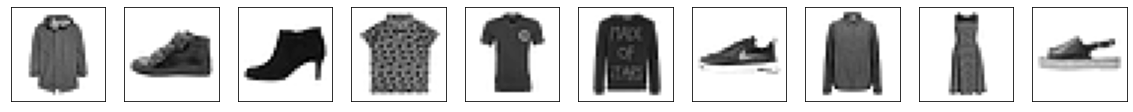

Reconstructed train images: 



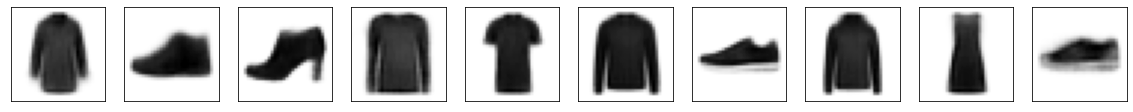

Randomly generated images: 



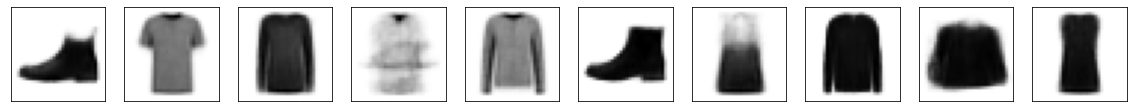

In [6]:
def plot_images(arr, title=None, img_count=25):
    print(title, '\n')
    plt.figure(figsize=(20,4))
    for i in range(img_count):
        plt.subplot(2, img_count, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = arr[i].reshape(height, width)
        plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

sample_size = 10

# Create test images array
indices = np.random.choice(len(train_images), size=sample_size, replace=False)
train_imgs = train_images[indices]

# Create reconstructed images array
reconstr_imgs = vae.predict(train_imgs)

# Create randomly generated samples array and construct images from them
random_normal_samples = np.array([K.random_normal(shape=(latent_dim, ), mean=0, 
                                        stddev=1) for i in range(sample_size)])
random_gen_imgs = decoder.predict(random_normal_samples)

plot_images(train_imgs, "Train images:", sample_size)
plot_images(reconstr_imgs, "Reconstructed train images:", sample_size)
plot_images(random_gen_imgs, "Randomly generated images:", sample_size)

## Task 4: Anomaly detection
**(a)** Use the VAE to obtain density/likelihood estimations for the normal and anomalous test sets, i.e. compute the ELBO (the negative of the loss function) for all points in both test sets. Make sure to keep the scores for the normal and anomaly sets separate from each other.

*Implementation hint: Unfortunately, Keras's `.evaluate()` does not allow to access the loss values of individual samples, it only returns the average loss over the entire input. A simple (but slow) workaround is to just use for loops over the entire input and use `.evaluate()` for each data point individually (set `verbose=0` to avoid a long output).*

In [7]:
n_images = test_images.shape[0]
img_elbo = n_images * [None]

for i in range(n_images):
    img_elbo[i] = -1 * vae.evaluate(x=test_images[i:i+1,:,:,:], verbose=0)

print(len(img_elbo))
print(np.average(img_elbo))

n_anomalies = test_anomalies.shape[0]
anom_elbo = n_anomalies * [None]

for i in range(n_anomalies):
    anom_elbo[i] = -1 * vae.evaluate(x=test_anomalies[i:i+1,:,:,:], verbose=0)

print(len(anom_elbo))
print(np.average(anom_elbo))

9000
-609.7793947550456
1000
-622.6739986572265


**(b)** Visualise the scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.

ELBO histogram


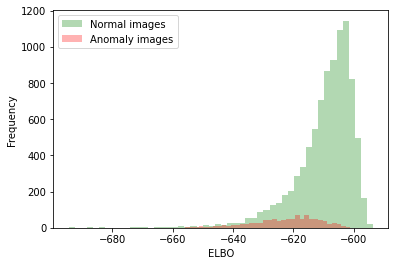

Density plot


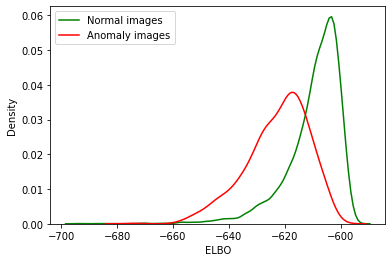

In [8]:
print("ELBO histogram")
plt.hist(img_elbo, color='green', alpha=0.3, label="Normal images", bins=50)
plt.hist(anom_elbo, color='red', alpha=0.3, label="Anomaly images", bins=50)
plt.legend()
plt.xlabel("ELBO")
plt.ylabel("Frequency")
plt.show()

print("Density plot")
sns.kdeplot(img_elbo, color = 'green', label="Normal images")
sns.kdeplot(anom_elbo, color = 'red', label="Anomaly images")
plt.xlabel("ELBO")
plt.ylabel("Density")
plt.show()

**(c)** Given these likelihood scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).
* Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.
* Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define anomaly as label 0 and normal as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*

ROC curve


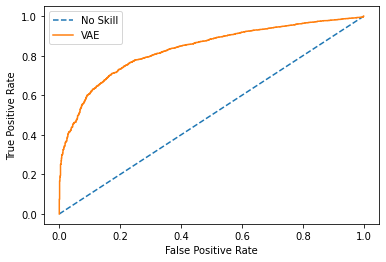

No Skill: ROC AUC=-0.000
VAE: ROC AUC=0.676


Precision-recall curve


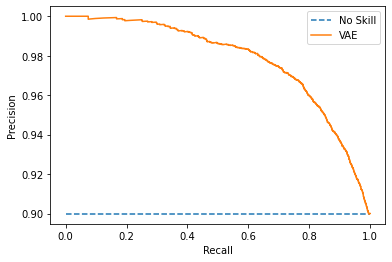

VAE: auc=0.978


In [9]:
# combine "normal" images and anomalies back into one test set
test_data = np.concatenate((test_images, test_anomalies), axis = 0)
# same for losses
test_losses = np.concatenate((img_elbo, anom_elbo), axis = 0)
# array of labels (first 9000 are normal, rest are anomalies)
test_labels = np.concatenate(([1] * 9000, [0] * 1000), axis = 0)

def min_max_scale(arr):
    x_min = np.min(arr)
    x_max = np.max(arr)
    res = []
    for i in range(len(arr)):
        X = arr[i]
        X_std = (X - x_min) / (x_max - x_min)
        res.append(X_std)
    
    return res

# normalize loss values to probabilities
probs =  min_max_scale(test_losses)



lr_probs = probs
ns_probs = [0] * 10000

print("ROC curve")
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_labels, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='VAE')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()



# quantitative evaluation
# calculate scores
ns_auc = auc(test_labels, ns_probs)
lr_auc = auc(test_labels, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VAE: ROC AUC=%.3f' % (lr_auc))
print("\n==================================================================\n")



lr_precision, lr_recall, _ = precision_recall_curve(test_labels, lr_probs)

print("Precision-recall curve")
# plot the precision-recall curves
no_skill = len(test_labels[test_labels==1]) / len(test_labels)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, label='VAE')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

#quantitative evaluation
lr_auc = auc(lr_recall, lr_precision)
print('VAE: auc=%.3f' % lr_auc)

**(d)** Ideally, a successful VAE for anomaly detection should represent (and thus reconstruct) normal data very well, but not anomalous data. Reconstruct some random images (at least 10 each) from the normal test set, as well as from the anomaly test set. Show the original images and their reconstructions on top of each other.

Test images: 



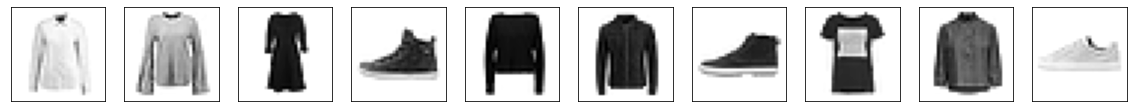

Reconstructed test images: 



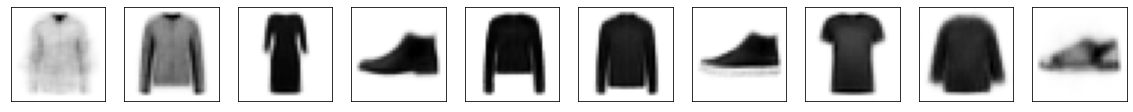

Anomaly images: 



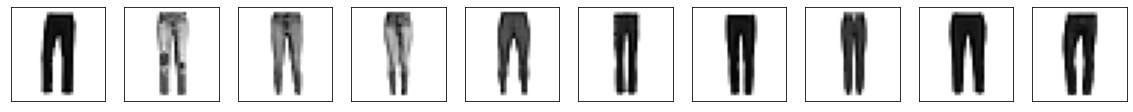

Reconstructed anomaly images: 



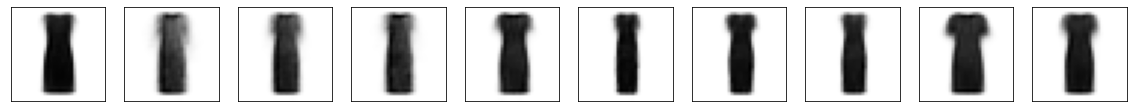

In [10]:
sample_size = 10

# Create test images arrays
test_indices = np.random.choice(len(test_images), size=sample_size, replace=False)
test_imgs = test_images[test_indices]
anomaly_indices = np.random.choice(len(test_anomalies), size=sample_size, replace=False)
anom_imgs = test_anomalies[anomaly_indices]

# Create reconstructed images arrays
reconstr_test_imgs = vae.predict(test_imgs)
reconstr_anom_imgs = vae.predict(anom_imgs)

plot_images(test_imgs, "Test images:", sample_size)
plot_images(reconstr_test_imgs, "Reconstructed test images:", sample_size)
plot_images(anom_imgs, "Anomaly images:", sample_size)
plot_images(reconstr_anom_imgs, "Reconstructed anomaly images:", sample_size)

**(e)** Give a detailed discussion of your results; does the anomaly detection perform well? Why do you think so? What could be improved? Discuss each of the results from parts (b), (c), and (d) separately.

_(b)_: The anomaly detection performs reasonably since the ELBO scores for the normal data is slightly higher. As the introduction discusses, ideally “normal” examples should obtain higher likelihood values than anomalous examples. This is clearly visible in the results.  

_(c)_: We can see that the Precision-Recall curve is indeed more suitable for our use case, because the test dataset is highly unbalanced. While the ROC curve suggests a highly performant model, the Precision-Recall curve shows that even when predicting all images as "normal" (label 1) (recall = 1), we still achieve an accuracy of 90% and that there is a trade-off when trying to achieve both, high accuracy and high recall. However, also the precision-recall curve and its auc_score of 0.978 indicate that our model is performing well in classifying images as normal and anomalies.

_(d)_: The reconstructions of the anomaly images represent dresses. This is not very surprising, since the trousers' long and narrow comes closest to the shape of a dress when looking at the training data. However, it is obvious that these reconstructions reproduce the trousers badly. If we compare this to the representations of the test images, it is clear to see that those are much better. With the test images' reconstructions, there is (almost) no doubt as what the images are supposed to be reconstructing. From this, we can conclude that the test classes were learned well, and the anomaly is not.

## Task 5: Peer review
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly work through the exercises? Do you think that some members of your group deserve a different grade from others?

__Luc__: We both did parts of every subtask, improving eachother's work, so I think we should both get the same grade.

__Gerrit__: We worked both on all tasks of the assignment, each one focusing on subtasks and helping each other when needed. I think we deserve the same grade.